In [3]:
# Импорт нужных модулей и библиотек
import sklearn.datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate 
import time 

In [4]:
# Константы
fu_color = '#166e70'
sec_color = 'r'
figsize_single = (8, 4)
figsize_dual = (18, 6)

# Введение

### В этой работе будут представлены методы машинного обучения в задачах анализа изображений.

### Нами будет решена задача многоклассовой классификации изображений.

Используем датасет **`Fashion MNIST`**, содержащий изображения элементов одежды. 
Каждое изображение имеет размер `28x28` пикселей и представлено в таблице как одномерный массив из `784` пикселей.

Для загрузки датасета воспользуемся встроенной в `sklearn` функцией `fetch_openml`, позволяющий загружать датасет из репозитория [openml.org](https://www.openml.org/).
Наш датасет находится по следующему URL: [ссылка](https://www.openml.org/search?type=data&status=active&id=40996&sort=runs)

In [5]:
# Загрузка данных из репозитория openml.com
X, y = sklearn.datasets.fetch_openml(data_id=40996, as_frame=True, return_X_y=True, parser='auto')

In [6]:
# Таблица признаков:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,31,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,27,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Cтолбец значений:
y

0        9
1        0
2        0
3        3
4        0
        ..
69995    9
69996    1
69997    8
69998    1
69999    5
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Таблица **`Х`** - датафрейм из `70000` строк и `784` столбцов, каждая строка которого является представлением изображения как 2-D массива `28x28`, элементами которого являются значения интенсивности цвета, сжатого до одного измерения. 

Столбец **`y`** размером `70000` показывает принадлежность каждого изображения к одной из `10` категорий.

 # Подготовка

## Предварительный анализ данных

Для начала убедимся, что в датасете нет пропущенных значений:

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


Видим, что пропущенных значений нет и все зачения всех признаков одного типа.

Выведем 3 случайных ихображения и названия их категорий:

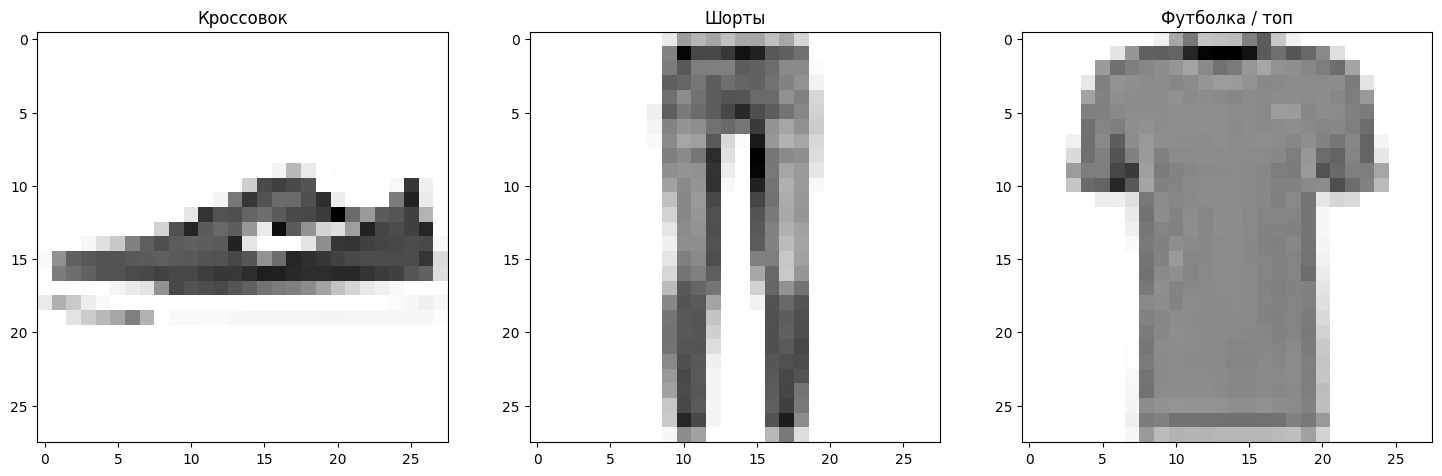

In [9]:
# Cловарь, сопоставляющий номеру категории ее название
decode_dict = {'0': 'Футболка / топ', '1': 'Шорты', '2': 'Свитер', '3': 'Платье', '4': 'Плащ', '5': 'Сандали', 
               '6': 'Рубашка', '7': 'Кроссовок', '8': 'Сумка', '9': 'Ботинок'} 

# Выведем 3 случайных изображения и названия их категорий
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(figsize_dual)

for i in range(3):
    n = np.random.randint(X.shape[0])
    axes[i].imshow(X.iloc[n].values.reshape(28, 28), cmap="Greys")
    axes[i].set(title=decode_dict[y.values[n]])
plt.show()

Для анализа представленных данных построим графики распределений среднего и максимальнго значения для каждого из `784` пикселей.

Вертикальные пунктирные линии на графиках - границы строк массива пикселей, позволяет оценить интенсивность пикселей на границах изображения.

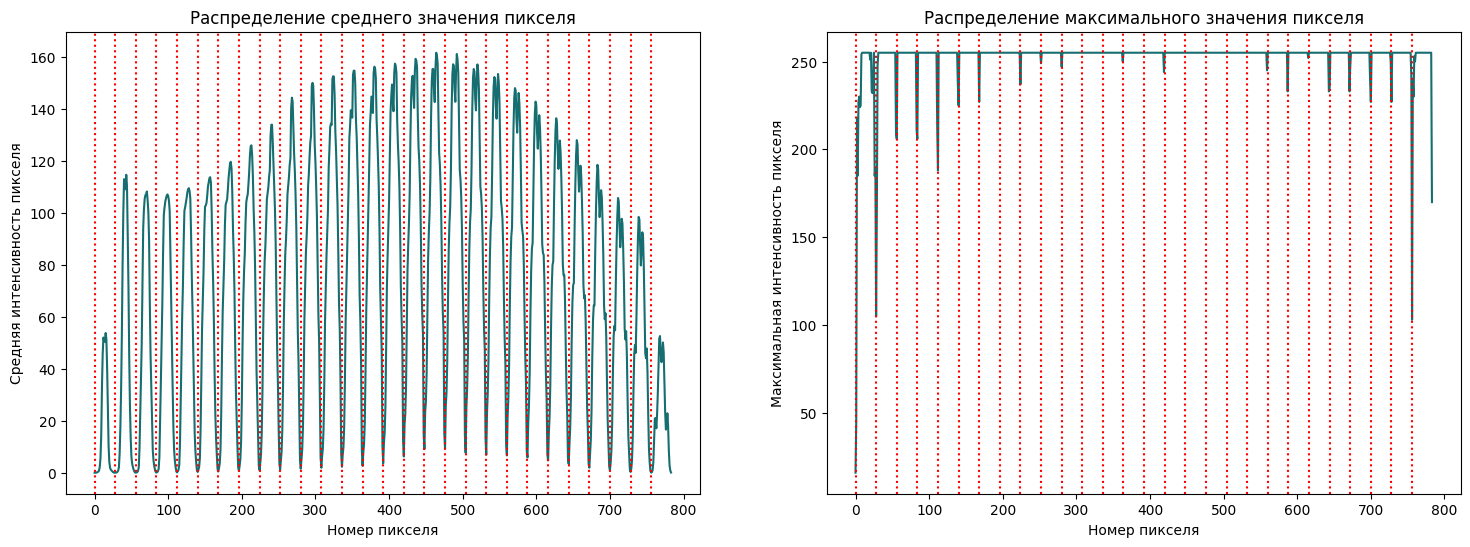

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(figsize_dual)

axes[0].set_ylabel('Средняя интенсивность пикселя')
axes[1].set_ylabel('Максимальная интенсивность пикселя')

axes[0].set(title='Распределение среднего значения пикселя')
axes[1].set(title='Распределение максимального значения пикселя')

axes[0].plot(range(0, 784), X.mean(axis=0).values, color=fu_color)
axes[1].plot(range(0, 784), X.max(axis=0).values, color=fu_color)
for ax in [0, 1]:
    [[axes[ax].axvline(x=i, color=sec_color, linestyle='dotted')]  for i in range(0, 784, 28)]
    axes[ax].set_xlabel('Номер пикселя')
plt.show()

Видно, что:
1. Исходя из первого графика пикселей растет ближе к середине изображения. Пик интенсивности находится чуть ниже середины изображения, в строках интенсивность достигает макисмума в середине.
2. Из второго графика видно, что нет пикселей, интенсивность которых равна нулю в каждом изображении датасета. Есть провалы в пикселях на границах изображения, что ожидаемо, так как объект расположен ближе к центру картинки.

Для более наглядного представения распределения плотности пикселей построим тепловую карту:

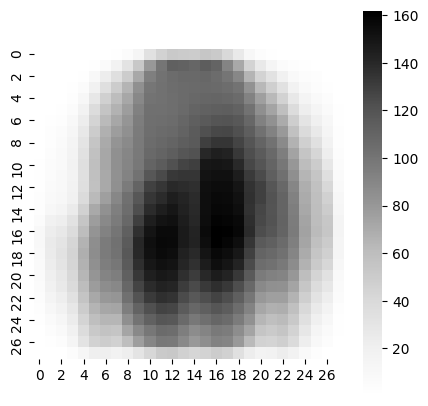

In [11]:
plt.figure(figsize=(5, 5))

sns.heatmap((X.mean(axis=0)).values.reshape(28, 28), cmap='Greys', square=True)
plt.show()

Также проанализируем массив метки классов:

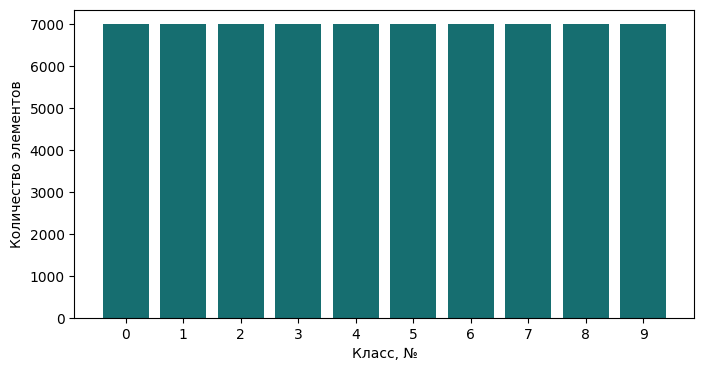

In [12]:
plt.figure(figsize=figsize_single)

plt.bar(y.value_counts().index, y.value_counts(), color=fu_color)
plt.xlabel('Класс, №')
plt.ylabel('Количество элементов')
plt.show()

Каждый класс равномерно представлен в датасете, что позволяет нам включить в выборки изображения, принадлежащие к каждому из классов в равном количестве.

## Разделение данных на выборки

Разделим датасет на обучающую, валидационную и тестовую выборки:
* **Обучающая выборка** нужна для обучения моделей (`70%` датасета).
* На **валидационной выборке** будет проходить первичное оценивание эффективности моделей и подбор гиперпараметров (`20%` датасета).
* На **тестовой выборке** будет проходить финальное оценивание эффективности модели (`10%` датасета).

С помощью параметра `stratify` сделаем так, чтобы в каждой выборке количество изображений каждого класса было равным. 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, 
    test_size=0.3333, 
    random_state=42,
    stratify=y_val_test)

samples = (X_train, y_train, X_val, y_val)

Выведем информацию о полученном разделении:

In [14]:
# Для визуализации таблиц используется пакет tabulate
table = [['Обучающая', y_train.shape[0], y_train.shape[0]/y.shape[0]*100], 
         ['Валидационная', y_val.shape[0], y_val.shape[0]/y.shape[0]*100], 
         ['Тестовая', y_test.shape[0], y_test.shape[0]/y.shape[0]*100]]
print(tabulate(table, headers=['Выборка', 'Размер, элем.', 'Размер, %'], numalign="left", tablefmt='mixed_grid'))

┍━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Выборка       │ Размер, элем.   │ Размер, %   │
┝━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ Обучающая     │ 49000           │ 70          │
├───────────────┼─────────────────┼─────────────┤
│ Валидационная │ 14000           │ 20          │
├───────────────┼─────────────────┼─────────────┤
│ Тестовая      │ 7000            │ 10          │
┕━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


В качестве метрик эффективности были выбраны точность (далее ***Accuracy***) и среднее гармоническое точности и полноты (далее ***F1 Score***).
* ***Accuracy*** покажет нам долю правильных предсказаний. В даннном случае эта метрика является показательной, так как распределение классов во всех выборках равномерно и не будет возникать так называемого "парадокса точности".
* ***F1 Score*** фактически покажет, насколько матрица ошибок ровная и насколько ошибки первого рода преобладают над ошибками второго рода и наоборот.

Также в качестве метрики ресурсоемкости будут использоваться времена обучения и предскзаания.

Для удобства применения различных моделей и визуализации эффективности напишем следующие функции:

In [64]:
# Таблица затраченного времени
def time_table(fit_time: float, predict_time: float) -> str:
    all_time = fit_time + predict_time
    table = [['Время обучения', fit_time, fit_time / all_time * 100],
             ['Время предсказания', predict_time, predict_time / all_time * 100],
             ['Общее время', all_time, 100]]
    header = ['Замер', 'Время, сек', 'Время, %']
    return tabulate(table, headers=header, numalign="left", tablefmt='mixed_grid', floatfmt=".5f")

# Таблица точности
def metrics_table(f1: float, accuracy: float) -> str:
    table = [['Accuracy', accuracy, accuracy * 100],
             ['F1 Score', f1, f1 * 100]]
    header = ['Метрика', 'Значение', 'Значение, %']
    return tabulate(table, headers=header, numalign="left", tablefmt='mixed_grid', floatfmt=".5f")

# Соединение таблиц
def merge_tables(time: str, metrics: str) -> str:
    return tabulate([[time, metrics]], headers = ['Время', 'Точность'], tablefmt='double_grid')

# Тепловая карта матрицы ошибок
def confusion_heatmap(y: tuple):
    y_true, y_pred = y
    plt.figure(figsize=figsize_single)
    axis_labels = decode_dict.values()
    sns.heatmap(sklearn.metrics.confusion_matrix(y_true, y_pred), annot=True, cmap='Greys', 
                 fmt='d', xticklabels=axis_labels, yticklabels=axis_labels)
    return plt.show()

from sklearn.metrics import accuracy_score, f1_score

# Обучение и предсказание модели
def fit_predict(model, samples: list) -> tuple:
    X_train, y_train, X_test, y_test = samples
    
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    model_fit = end - start

    start = time.time()
    y_pred = model.predict(X_test)
    end = time.time()
    model_predict = end - start
    
    f1 = f1_score(y_test, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    return ((time_table(model_fit, model_predict), metrics_table(f1, accuracy)),
            (y_test, y_pred),
            (model_fit, model_predict),
            (f1, accuracy))

## Построение моделей

### Линейные модели

Для этих моделей предпочтительно, чтобы данные были линейно-разделимы.
Для обучения линейных моделей используется метод один-против-всех, при котором модель во время тренировки считает классы, отличные от класса заданного объекта, единым вторым классом.

#### 1. Логистическая регрессия

Логистическая регрессия - линейная статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.

In [65]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 13.86663     │ 99.76657   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.03244      │ 0.23343    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 13.89908     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.85100    │ 85.10000      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.84974    │ 84.97368      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


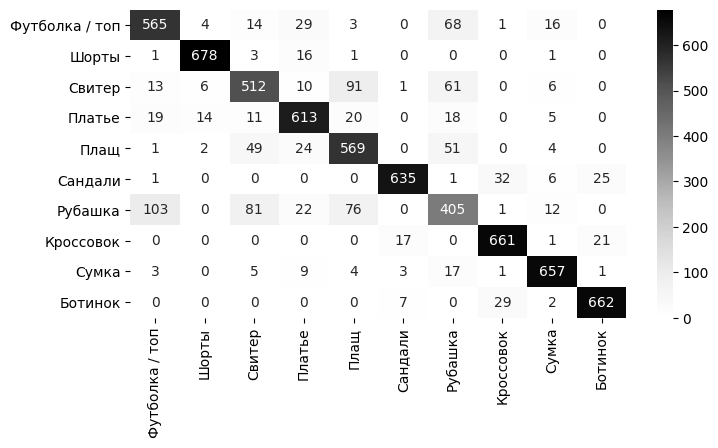

In [66]:
logistic_result = fit_predict(logistic, samples)

print(logistic_result[0][0])
print(logistic_result[0][1])
confusion_heatmap(logistic_result[1])

Видим, что модель не обучилась до конца и процесс обучения завершился по завершению максимального количества итераций.

Исследуем значения точности предсказаний модели при различном количестве итераций. Для этого соберем данные об обучении и точности моделей при разных количествах итераций. Возьмем диапазон итераций от `100` до `1000` с шагом `100`:

In [18]:
max_iter = 1000
count_iter = []
acc_score = []
learn_time = []

for c_i in range(100, max_iter+1, 100):
    count_iter.append(c_i)
    logistic = LogisticRegression(max_iter=c_i)
    
    start = time.time()
    logistic.fit(X_train, y_train)
    y_pred = logistic.predict(X_val)
    end = time.time()
    
    learn_time.append(end - start)
    acc_score.append(sklearn.metrics.accuracy_score(y_val, y_pred))

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Из предупреждений `ConvergenceWarning` видно, что даже при 1000 итерациях модель не обучилась до конца.\
Визуализируем полученную информацию.

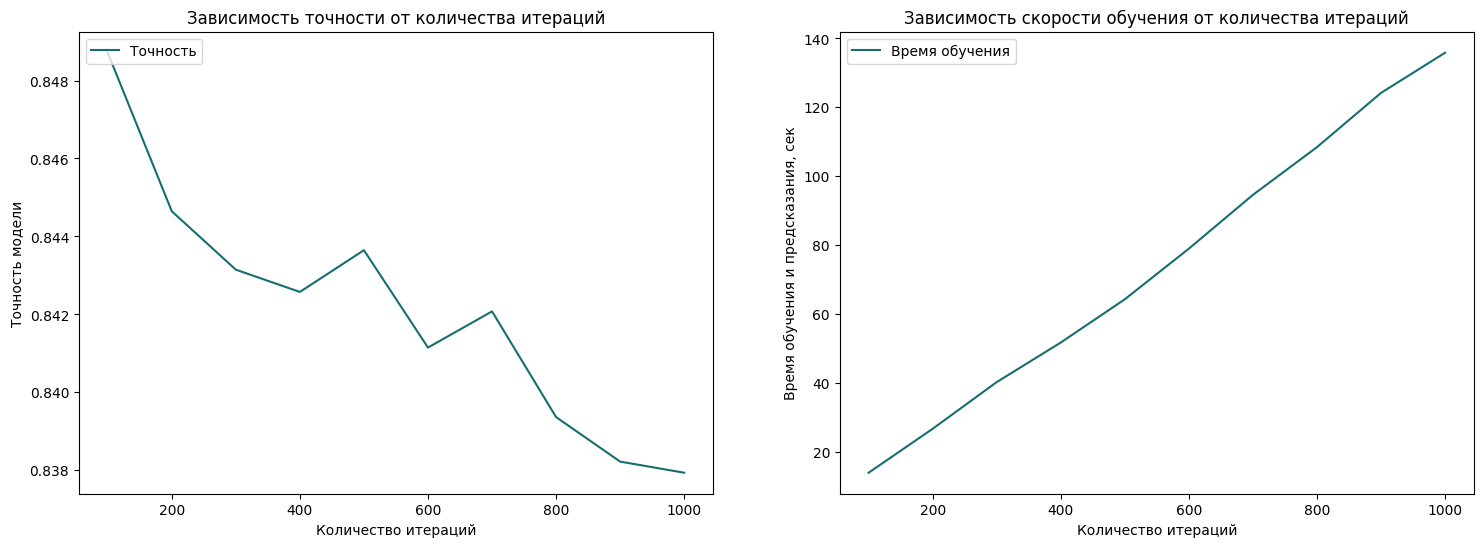

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(figsize_dual)

axes[0].set_ylabel('Точность модели')
axes[1].set_ylabel('Время обучения и предсказания, сек')

axes[0].set(title='Зависимость точности от количества итераций')
axes[1].set(title='Зависимость скорости обучения от количества итераций')

axes[0].plot(count_iter, acc_score, color=fu_color, label="Точность")
axes[1].plot(count_iter, learn_time, color=fu_color, label="Время обучения")
for ax in [0, 1]:
    axes[ax].legend(loc="upper left")
    axes[ax].set_xlabel('Количество итераций')
plt.show()

Мы видим, что:
* Время, затраченное на обучение модели и предсказание результа возрастает практически линейно.
* Есть тенденция к уменьшению точности модели при увеличении количества итераций, что может говорить о переобучении.

Посмотрим на матрицу ошибок при самом большом количестве итераций из исследования выше:

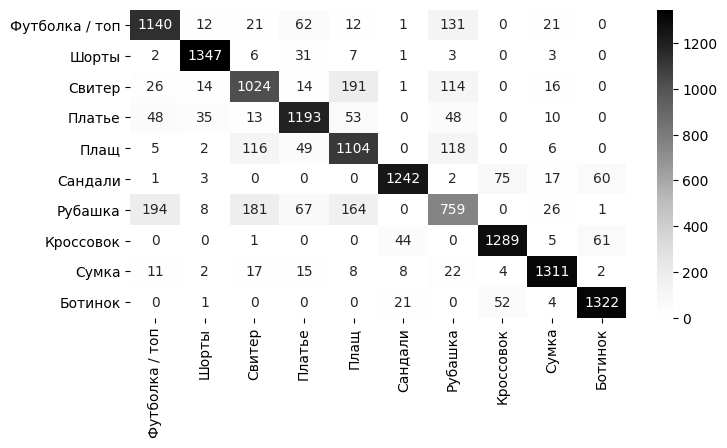

In [20]:
confusion_heatmap((y_val, y_pred))

Видно, что модель часто ошибается в предсказаниях "похожих" классов:
* Плохо определяет рубашки, считая их футболками, свитерами и плащами.
* Нередко неверно предсказывает свитера и плащи.

Результаты выше говорят о том, что модель логистической регрессии плохо подходит для нашей задачи, так как с трудом различает "похожие" классы.

#### 1*. Полиномиальная модель

Попробуем улучшить предыдущую модель, введя полиномиальные признаки:

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_logistic= make_pipeline(PolynomialFeatures(), LogisticRegression())

In [22]:
poly_logistic_result = fit_predict(poly_logistic, samples)

print(poly_logistic_result[0])
confusion_heatmap(poly_logistic_result[1])

MemoryError: Unable to allocate 113. GiB for an array with shape (49000, 308505) and data type float64

Видим, что появилась ошибка `MemoryError`, сообщающая о нехватки памяти. Так как мы имеем довольно много признаков (`784`), то использование полиномиальной модели очень ресурсозатратно и безперспективно.

#### 2. Перцептрон

Следующей линейной моделью применим перцептрон. Эта модель в качестве функции ошибки использует так называемый *критерий перцептрона*.

In [67]:
from sklearn.linear_model import Perceptron

perc = Perceptron()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 7.63235      │ 99.58077   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.03213      │ 0.41923    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 7.66448      │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.80743    │ 80.74286      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.79995    │ 79.99481      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


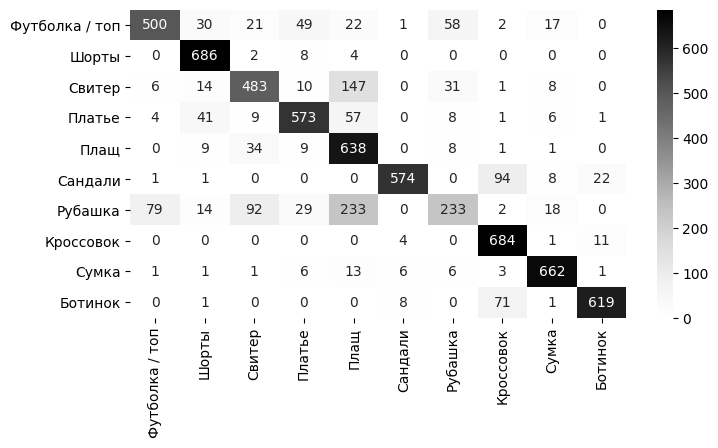

In [68]:
perc_result = fit_predict(perc, samples)

print(perc_result[0][0])
print(perc_result[0][1])
confusion_heatmap(perc_result[1])

Результаты работы этой модели хуже результатов работы логистической регресии, виден сильный дисбаланс в матрице ошибок.

#### 3. Пассивно-агрессивный классификатор

Дальнейшей моделью для изучения станет пассивно-агрессивный классификатор. Эта модель, как и перцептрон, меняет себя только при получении ложного прогноза, но в отличие от него, имеет возможность настройки параметра регуляризации `C`.\
*Параметр регуляризации* - мера степени наказания модели за каждый неверно классифицированный объект.

In [69]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa = PassiveAggressiveClassifier(C=1.0) # Значение С по умолчанию

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 11.01843     │ 99.70517   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.03258      │ 0.29483    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 11.05101     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.80300    │ 80.30000      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.78505    │ 78.50480      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


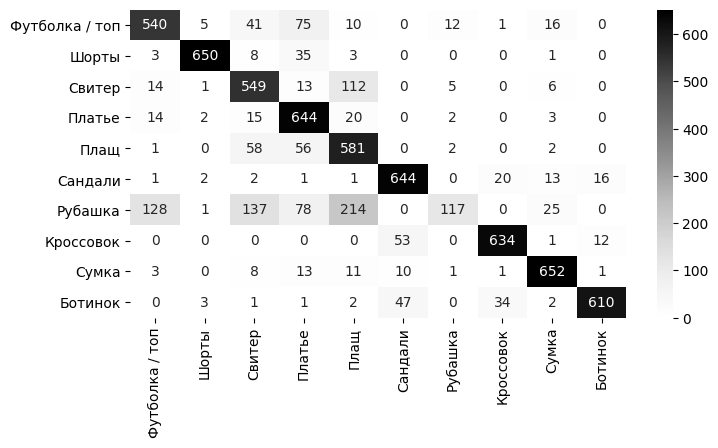

In [70]:
pa_result = fit_predict(pa, samples)

print(pa_result[0][0])
print(pa_result[0][1])
confusion_heatmap(pa_result[1])

При значении `C = 1.0` результаты точности ниже, чем у перцептрона. Исследуем зависимость точности и времени обучения от значения `C`:

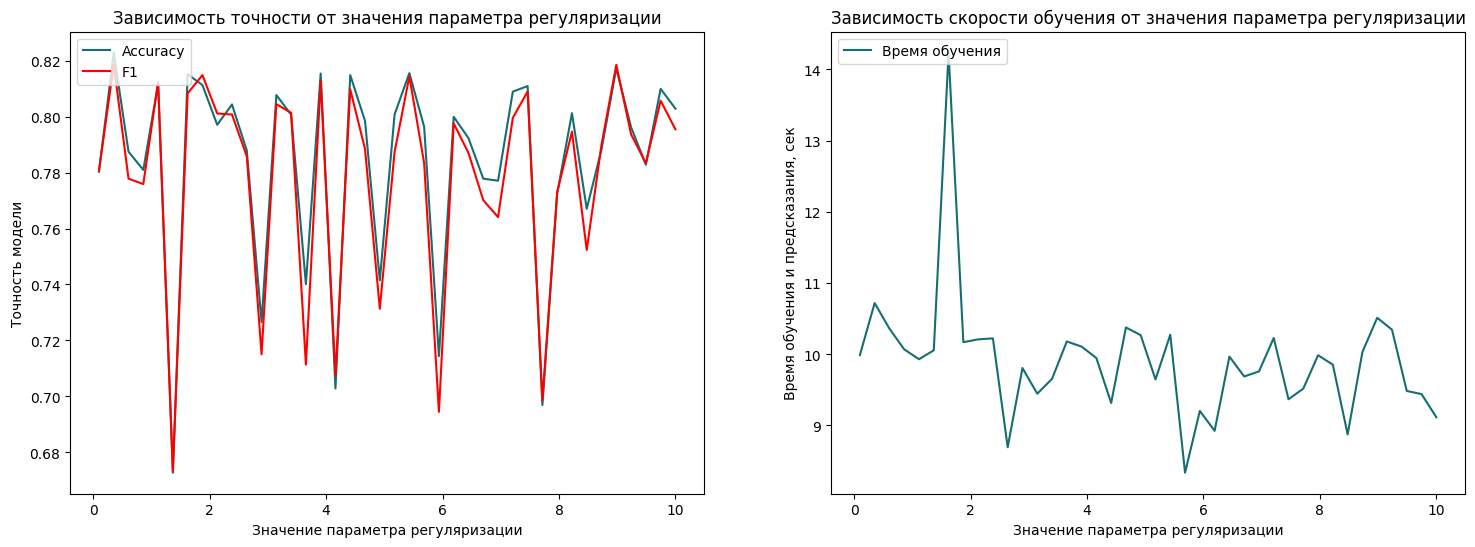

In [27]:
f1 = []
accuracy = []
fit_predict_time = []

C_values = np.linspace(0.1, 10, 40)
for C in C_values:
    results = fit_predict(PassiveAggressiveClassifier(C=C), samples)
    fit_predict_time.append(sum(results[2]))
    f1.append(results[3][0])
    accuracy.append(results[3][1])
    
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(figsize_dual)

axes[0].set_ylabel('Точность модели')
axes[1].set_ylabel('Время обучения и предсказания, сек')

axes[0].set(title='Зависимость точности от значения параметра регуляризации')
axes[1].set(title='Зависимость скорости обучения от значения параметра регуляризации')

axes[0].plot(C_values, accuracy, color=fu_color, label="Accuracy")
axes[0].plot(C_values, f1, color=sec_color, label="F1")
axes[1].plot(C_values, fit_predict_time, color=fu_color, label="Время обучения")
for ax in [0, 1]:
    axes[ax].legend(loc="upper left")
    axes[ax].set_xlabel('Значение параметра регуляризации')
plt.show()

Графики выше говорят о том, что в нашем случае значение параметра регуляризации не сильно влияет на точность предсказания. Скорость обучения и предсказания при этом находится в узком диапазоне 8.5-11 сек., что ожидаемо, так как значение `C` не меняет структуру модели и не "усложняет" её.

### Алгоритмы ближайших соседей

Используем метод k ближайших соседей. При работе этого метода объект присваивается тому классу, который является наиболее распространённым среди k соседей данного элемента, классы которых уже известны.

In [71]:
from sklearn.neighbors import KNeighborsClassifier

kneigh = KNeighborsClassifier()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 0.22418      │ 2.22572    │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 9.84827      │ 97.77428   │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 10.07245     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.85529    │ 85.52857      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.85425    │ 85.42492      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


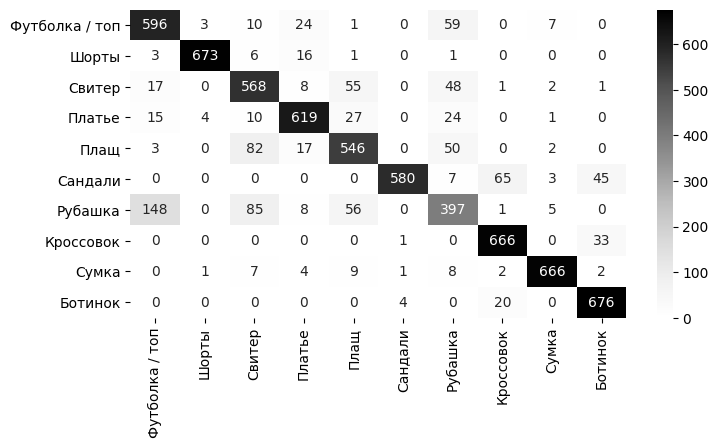

In [72]:
kneigh_result = fit_predict(kneigh, samples)

print(kneigh_result[0][0])
print(kneigh_result[0][1])
confusion_heatmap(kneigh_result[1])

После работы этой модели видим, что матрица ошибок более "ровная", чем в предыдущих случаях при использовании линейных моделей.

### Наивные байесовские классификаторы

Гипотеза наивного байесовского классификатора утверждает, что каждый объект в наборе данных вносит независимый и равный вклад в предсказание меток.

Проще говоря, мы можем сказать, что нет никакой корреляции между функциями и что каждая функция имеет одинаковое значение для формирования модели классификации.

Эти предположения обычно неверны при работе с реальными задачами, но алгоритм все же работает хорошо, поэтому он известен как «наивный» байесовский алгоритм.

#### 1. Гауссовский наивный байесовский классификатор

В качестве первого классификатора из этой категории применим Гауссовский.

Он хорошо работает, когда набор данных распределен нормально.

In [73]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 0.76236      │ 66.36893   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.38631      │ 33.63107   │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 1.14867      │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.58529    │ 58.52857      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.55673    │ 55.67257      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


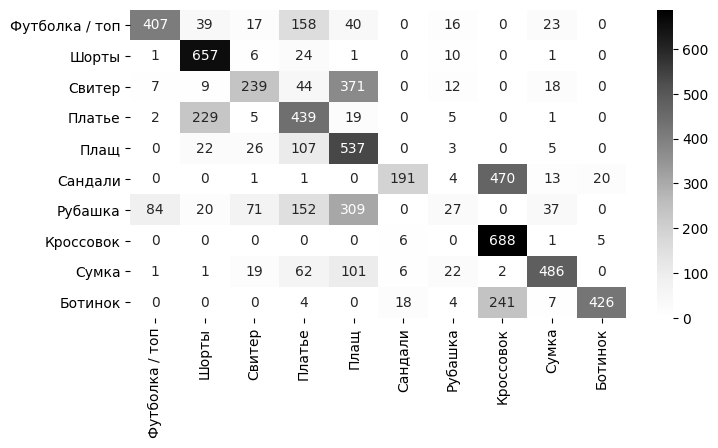

In [74]:
gnb_result = fit_predict(gnb, samples)

print(gnb_result[0][0])
print(gnb_result[0][1])
confusion_heatmap(gnb_result[1])

Видим, что модель плохо подходит под наши задачи, имеет низкую точность и часто ошибается. При этом величина времени, затраченного на работу этой модели, значительно меньше времени работы предыдущих моделей, но в сочетании с низкой точностью это преимущество не так важно.

#### 2. Мультибиномиальный наивный байесовский классификатор

Используем мультибиномиальный наивный байесовский классификатор.

In [75]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 0.80281      │ 96.08944   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.03267      │ 3.91056    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 0.83548      │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.65743    │ 65.74286      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.62927    │ 62.92738      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


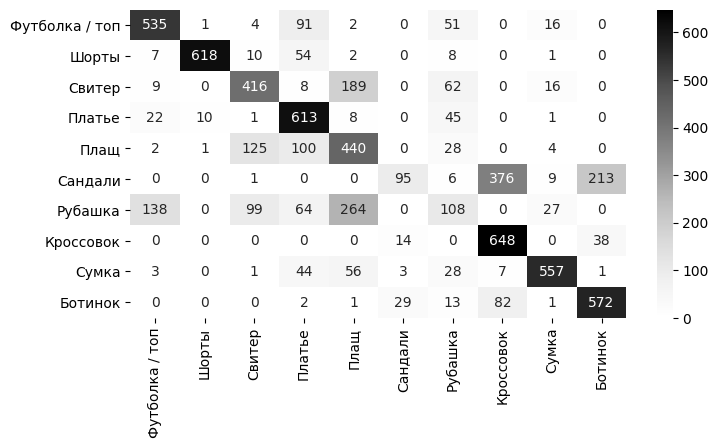

In [76]:
mnb_result = fit_predict(mnb, samples)

print(mnb_result[0][0])
print(mnb_result[0][1])
confusion_heatmap(mnb_result[1])

Видим, что модель практически не тратит времени на обучение и предсказание результата. При этом точность мультибиномиального классификатора выше, чем у гауссовского, однако специфика работы наивных байесовских моделей и полученные выше результаты говорят о том, что модели этой категории не смогут решать нашу задачу по классификации изображений с высокой точностью.

### Деревья решений

Дерево решений представляет собой иерархическую древовидную структуру, состоящую из правила вида «Если …, то ...». За счет обучающего множества правила генерируются автоматически в процессе обучения.

Применим к данным модель дерева решений:

In [77]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 31.57342     │ 99.93188   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.02152      │ 0.06812    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 31.59494     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.78971    │ 78.97143      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.78995    │ 78.99501      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


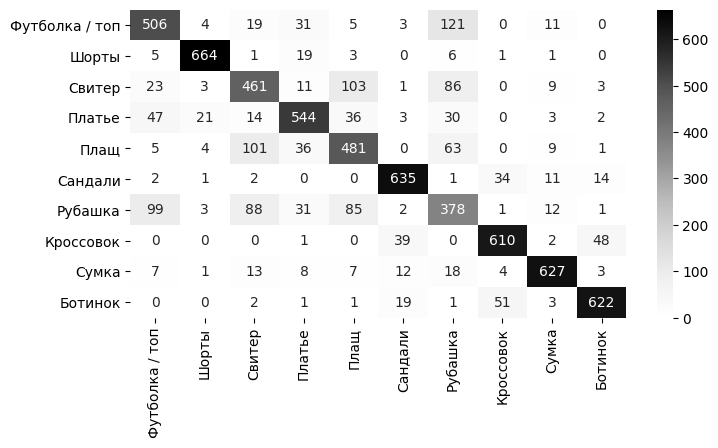

In [78]:
dt_result = fit_predict(dt, samples)

print(dt_result[0][0])
print(dt_result[0][1])
confusion_heatmap(dt_result[1])

Видим, что точноть модели несколько ниже или равна точности линейных моделей, примененных ранее. Однако матрица ошибок более симметричная и возможно, настройка модели улучшит результат.

### Ансамбли алгоритмов

Ансамбль алгоритмов (методов) — метод, который использует несколько обучающих алгоритмов с целью получения лучшей эффективности прогнозирования, чем можно было бы получить от каждого обучающего алгоритма по отдельности. 

#### 1. Случайный лес

Случайный лес — модель, состоящая из множества деревьев решений.

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 73.11303     │ 99.51490   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.35640      │ 0.48510    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 73.46943     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.88243    │ 88.24286      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.88064    │ 88.06401      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


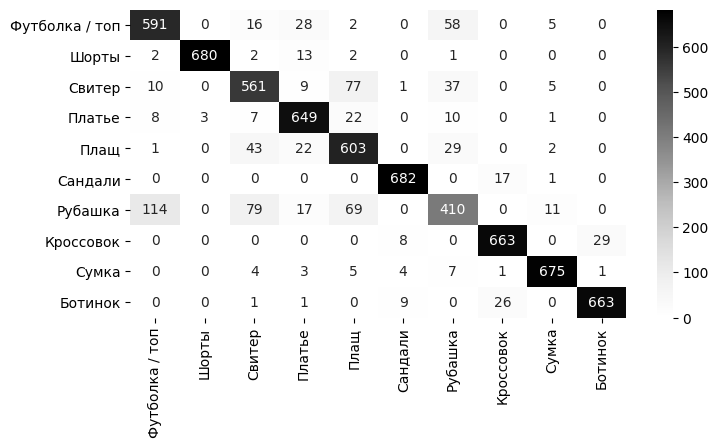

In [80]:
rf_result = fit_predict(rf, samples)

print(rf_result[0][0])
print(rf_result[0][1])
confusion_heatmap(rf_result[1])

Так как модель случайного леса является совокупностью нескольких деревьев решений, ожидаемо видим увеличение точности предсказания и времени на обучение модели.

#### 2. Дополнительные деревья

Модель дополнительных деревьев, как и алгоритм случайных лесов, создает много деревьев решений, но выборка для каждого дерева случайна, без замены. Это создает набор данных для каждого дерева с уникальными образцами. Конкретное количество признаков, из общего набор признаков, также выбираются случайным образом для каждого дерева.

In [81]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 36.13820     │ 98.93323   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.38967      │ 1.06677    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 36.52787     │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.87986    │ 87.98571      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.87830    │ 87.83010      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


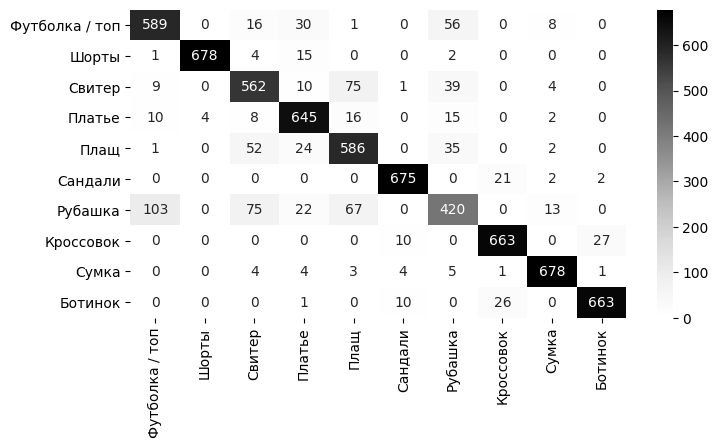

In [82]:
et_result = fit_predict(et, samples)

print(et_result[0][0])
print(et_result[0][1])
confusion_heatmap(et_result[1])

Эта модель показала практически такую же точность, как и случайный лес, однако скорость обучения и предсказания уменьшилась на 50%.

#### 3. Градиентный бустинг

Если идея работы предыдущих ансамблей была в построении нескольких независимых моделей и усреднения их результатов работы (такой подход называется *бэггинг*), то идея градиентного бустинга - использовать эти же модели, но последовательно, при чем каждая последующая модель учится на ошибках предыдущей.

In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier()

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 184.12207    │ 99.91148   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.16313      │ 0.08852    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 184.28520    │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.89757    │ 89.75714      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.89703    │ 89.70262      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


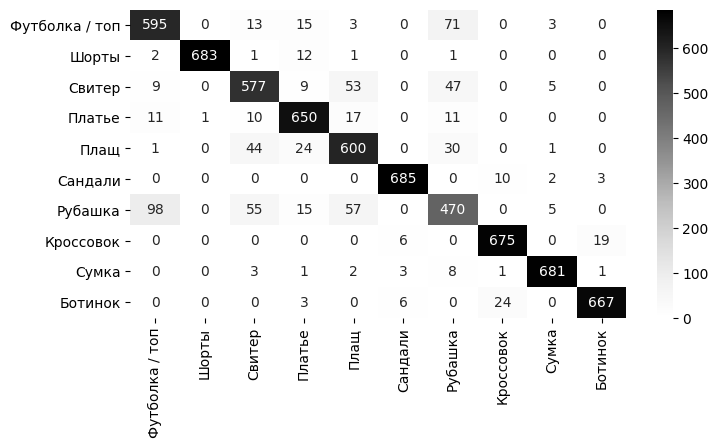

In [84]:
hgb_result = fit_predict(hgb, samples)

print(hgb_result[0][0])
print(hgb_result[0][1])
confusion_heatmap(hgb_result[1])

Эта модель показала набольшую точность среди всех выше представленных алгоритмов. При это сильно возросла и скорость обучения.

## Выбор перспективной модели

Соберем результаты работы моделей в таблице:

In [43]:
models = ['Логистическая регрессия', 'Перцептрон', 'Пассивно-агрессивный классификатор', 
          'Метод ближайших соседей', 'Гауссовский байесовский классификатор', 
          'Мультибиномиальный байесовский классификатор', 'Дерево решений', 
          'Случайный лес', 'Дополнительные деревья', 'Градиентный бустинг']
models_res = [logistic_result, perc_result, pa_result, kneigh_result, gnb_result, 
              mnb_result, dt_result, rf_result, et_result, hgb_result]

models_acc = list(map(lambda x: x[3][1], models_res))
models_f1 = list(map(lambda x: x[3][0], models_res))
models_fit_time = list(map(lambda x: x[2][0], models_res))
models_pred_time = list(map(lambda x: x[2][1], models_res))

results = pd.DataFrame({'Модель': models,
                   'Время обучения': models_fit_time,
                   'Время предсказания': models_pred_time, 
                   'Общее время': np.array(models_pred_time) + np.array(models_fit_time),
                   'F1 Score': models_f1,
                   'Accuracy': models_acc})
results.set_index(results.columns[0], inplace=True)
results

,Время обучения,Время предсказания,Общее время,F1 Score,Accuracy
Модель,,,,,
Логистическая регрессия,13.652494,0.058851,13.711344,0.847397,0.848714
Перцептрон,7.701537,0.052999,7.754537,0.803104,0.809571
Пассивно-агрессивный классификатор,10.965328,0.053446,11.018774,0.721066,0.748714
Метод ближайших соседей,0.305511,19.481148,19.786659,0.854633,0.855429
Гауссовский байесовский классификатор,0.760568,0.769250,1.529818,0.568771,0.596857
Мультибиномиальный байесовский классификатор,0.810781,0.057032,0.867813,0.638278,0.667071
Дерево решений,31.292128,0.040409,31.332537,0.796274,0.795571
Случайный лес,74.229634,0.871132,75.100765,0.881494,0.883286
Дополнительные деревья,37.067878,0.793707,37.861585,0.880977,0.882786


Визализируем информацию о времени обучения и предсказания и точности моделей:

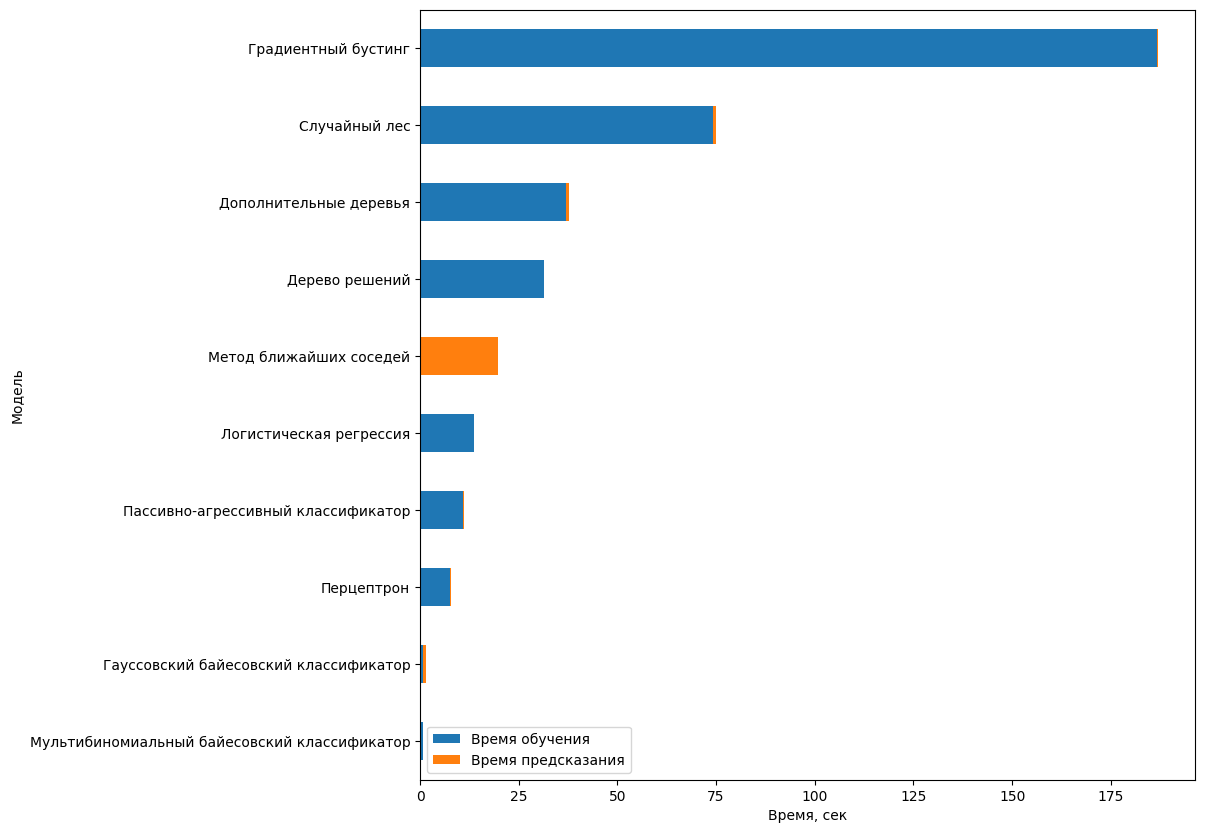

In [46]:
ax = results.sort_values('Общее время', ascending=True)[['Время обучения', 'Время предсказания']].plot(kind="barh", stacked=True, figsize=(10, 10), xlabel='')
ax.set_xlabel("Время, сек")
plt.show()

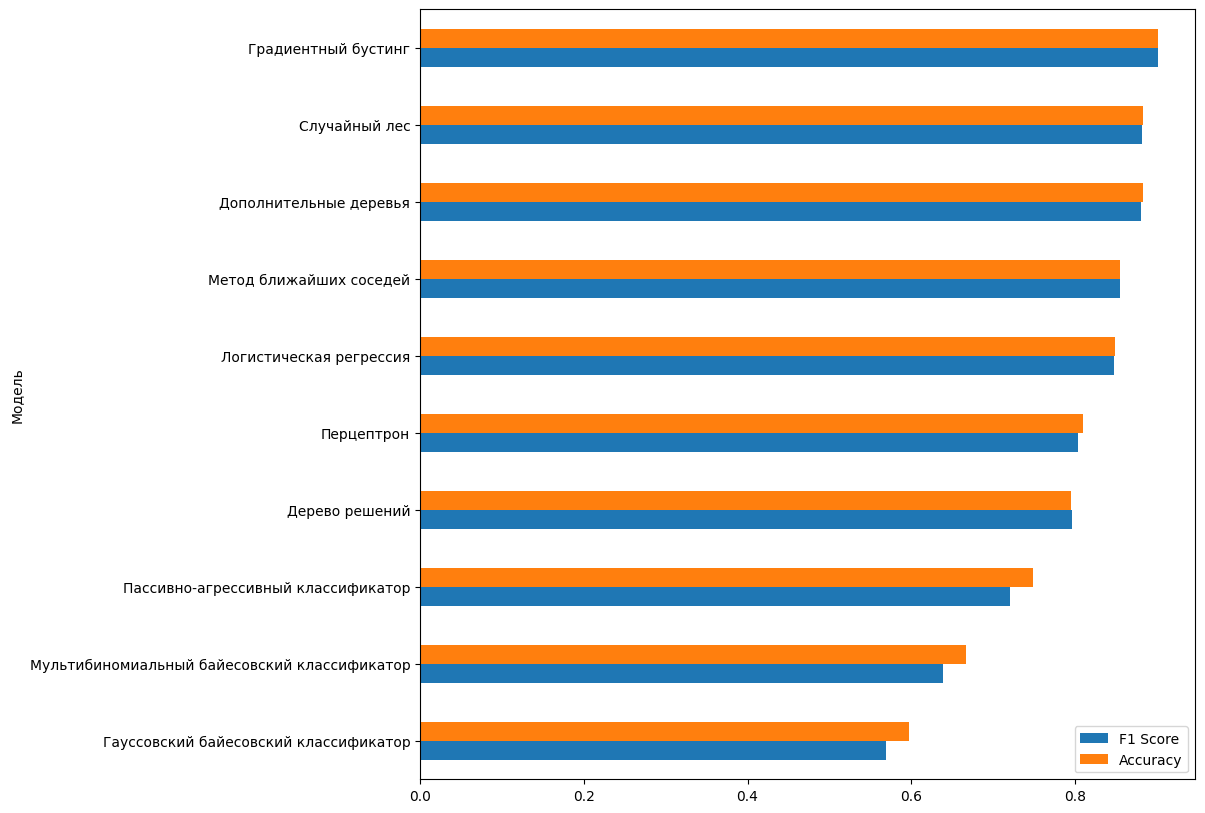

In [49]:
ax = results.sort_values('Accuracy', ascending=True)[['F1 Score', 'Accuracy']].plot(kind="barh", stacked=False, figsize=(10, 10), xlabel='')
plt.show()

Ожидаемо, что самыми результативными моделями оказались ансамбли методов: случайный лес, дополнительные деревья и дерево классификации градиентного бустинга.
При этом модель случайного леса на 66% быстрее дерева классификации градиентного бустинга, а алгоритм дополнительных деревьев на 30% быстрее случайного леса.
Точности предсказаний этих моделей находятся в диапазоне 88-90%.

Однако, чтобы сделать выбор между методом дополнительных деревьев и алгоритмом дерева классфикации градиентного бустинга, нужно проанализировать зависимость между точностью и параметром `n_estimators` (кол-во деревье в лесу) в модели дополнительных деревьев. 

Прим: так как точность этих моделей сильно зависит от кол-ва деревьев в лесу, и время обучения практически линейно зависит от этой величины, то может возникнуть ситуация, что максимальная точность модели дополнительных решений с параметрами, при которых время обучения будет примерно равно времени обучения модели градиентного бустинга, будет равна точности этого классификатора при значениях гиперпараметров по умолчанию.
Грубо говоря, если взять метод дополнительных деревьев как "компромиссный" вариант из-за небольшого времени обучения и хорошей точности, и подобрать оптимальные гиперпараметры, то время обучения этой модели может сравняться с временем работы алгоритма градиентного бустинга, при этом точность выбранной модели будет ниже.

Построим следующий график:

In [52]:
et_accuracy = []
et_fit_preduct_time = []
hgb_time = hgb_result[2][0] + hgb_result[2][1]
hgb_accuracy = hgb_result[3][1]

max_n_estimators = hgb_time / (et_result[2][0] + et_result[2][1]) * 100
default_n_estimators = 100
x = np.linspace(default_n_estimators, max_n_estimators, 10)

samples = (X_train, y_train, X_val, y_val)
for n_estimators in x:
    model = ExtraTreesClassifier(n_estimators=int(n_estimators))
    result = fit_predict(model, samples)
    et_fit_preduct_time.append(result[2][0] + result[2][1])
    et_accuracy.append(result[3][1])

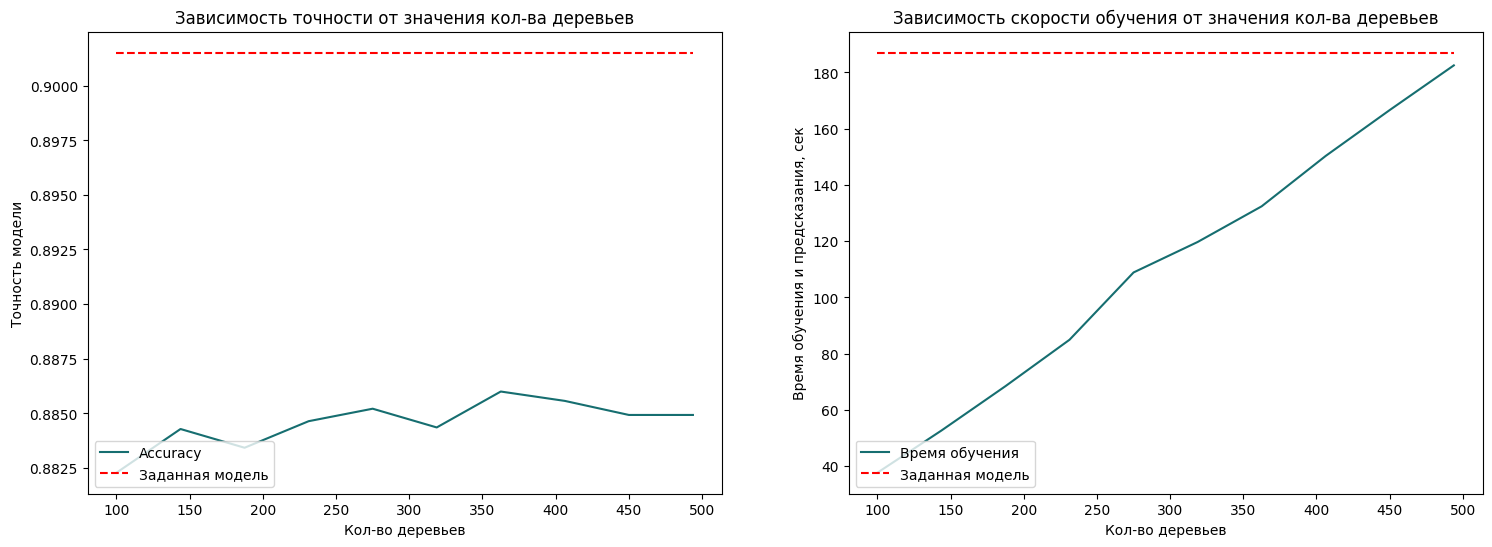

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(figsize_dual)

axes[0].set_ylabel('Точность модели')
axes[1].set_ylabel('Время обучения и предсказания, сек')

axes[0].set(title='Зависимость точности от значения кол-ва деревьев')
axes[1].set(title='Зависимость скорости обучения от значения кол-ва деревьев')

axes[0].plot(x, et_accuracy, color=fu_color, label="Accuracy")
axes[0].hlines(y=hgb_accuracy, xmin=min(x), xmax=max(x), linestyle='--', color='r', label='Заданная модель')

axes[1].plot(x, et_fit_preduct_time, color=fu_color, label="Время обучения")
axes[1].hlines(y=hgb_time, xmin=min(x), xmax=max(x), linestyle='--', color='r', label='Заданная модель')
for ax in [0, 1]:
    axes[ax].legend(loc="lower left")
    axes[ax].set_xlabel('Кол-во деревьев')
plt.show()

По графикам видно, что наша гипотеза подтвердилась: время на обучение и предсказание одной модели сравнялись с другой, а точность не превысила точность заданной модели.

В качестве наиболее перспективной модели выберем градиентный бустинг.

## Улучшение модели

Для улучшения эффективности выбранной перспективной модели нужно подобрать гиперпарарметры. Гиперпараметры — это характеристики модели, которые фиксируются до начала обучения.

Для автоматического подбора гиперпараметров будем использовать модуль `GridSearchCV`. Он находит наилучшие параметры, путем обычного перебора: создает модель для каждой возможной комбинации параметров и измеряет её эффективность. Этот метод довольно времязатратный, но благодаря автоматизации процесса поиска и оценки точности удобен в использовании.

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
model = HistGradientBoostingClassifier()

# Сетка подбираемых параметров
param_grid = {
    'learning_rate': [0.01, 0.1, 10.0],
    'max_leaf_nodes': [31, 50, 100],
    'min_samples_leaf': [20, 40, 60]}

In [868]:
# Подбор параметров
grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 10.0],
                         'max_leaf_nodes': [31, 50, 100],
                         'min_samples_leaf': [20, 40, 60]},
             scoring='accuracy')

In [57]:
# Оптимальные параметры модели
best_params = grid.best_params_
best_params

{'learning_rate': 0.1, 'max_leaf_nodes': 50, 'min_samples_leaf': 40}

## Финальная оценка эффективности

Результат применения модели с подобранными гиперпарaметрами. Оценка качества будет производиться на тестовом наборе.

┍━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━┯━━━━━━━━━━━━┑
│ Замер              │ Время, сек   │ Время, %   │
┝━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━┿━━━━━━━━━━━━┥
│ Время обучения     │ 257.59922    │ 99.90560   │
├────────────────────┼──────────────┼────────────┤
│ Время предсказания │ 0.24341      │ 0.09440    │
├────────────────────┼──────────────┼────────────┤
│ Общее время        │ 257.84263    │ 100.00000  │
┕━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━┷━━━━━━━━━━━━┙
┍━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━━━━━━━━┑
│ Метрика   │ Значение   │ Значение, %   │
┝━━━━━━━━━━━┿━━━━━━━━━━━━┿━━━━━━━━━━━━━━━┥
│ Accuracy  │ 0.89914    │ 89.91429      │
├───────────┼────────────┼───────────────┤
│ F1 Score  │ 0.89892    │ 89.89213      │
┕━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━━━━━━━━┙


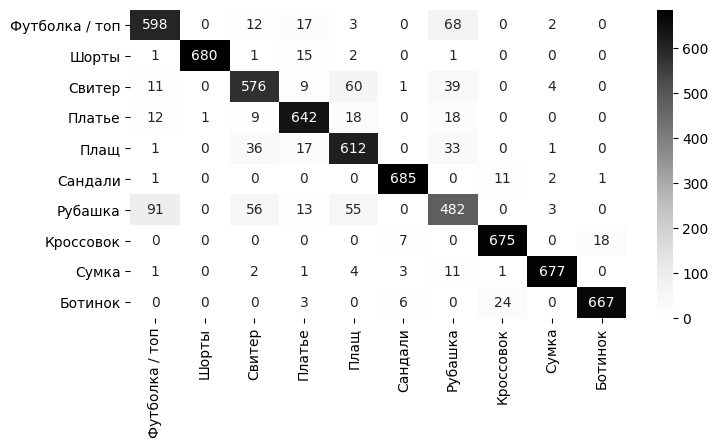

In [85]:
samples = (X_train, y_train, X_test, y_test)

tuning_hgb = HistGradientBoostingClassifier(**best_params)

tuning_hgb_result = fit_predict(tuning_hgb, samples)

print(tuning_hgb_result[0][0])
print(tuning_hgb_result[0][1])
confusion_heatmap(tuning_hgb_result[1])

Сравнинм эффективность выбранной модели до и после подбора гиперпараметров. Оценка качества будет производиться на тестовом наборе.

In [60]:
default_hgb = HistGradientBoostingClassifier()

default_hgb_result = fit_predict(default_hgb, samples)

models = ['Гиперпараметры по умолчанию', 'Подобранные гиперпараметры']
models_res = [default_hgb_result, tuning_hgb_result]
models_acc = list(map(lambda x: x[3][1], models_res))
models_f1 = list(map(lambda x: x[3][0], models_res))
models_fit_time = list(map(lambda x: x[2][0], models_res))
models_pred_time = list(map(lambda x: x[2][1], models_res))

results = pd.DataFrame({'Модель': models,
                   'Время обучения': models_fit_time,
                   'Время предсказания': models_pred_time, 
                   'Общее время': np.array(models_pred_time) + np.array(models_fit_time),
                   'F1 Score': models_f1,
                   'Accuracy': models_acc})
results.set_index(results.columns[0], inplace=True)
results

,Время обучения,Время предсказания,Общее время,F1 Score,Accuracy
Модель,,,,,
Гиперпараметры по умолчанию,202.314751,0.176289,202.491040,0.895489,0.895857
Подобранные гиперпараметры,254.655726,0.283058,254.938784,0.896326,0.897000


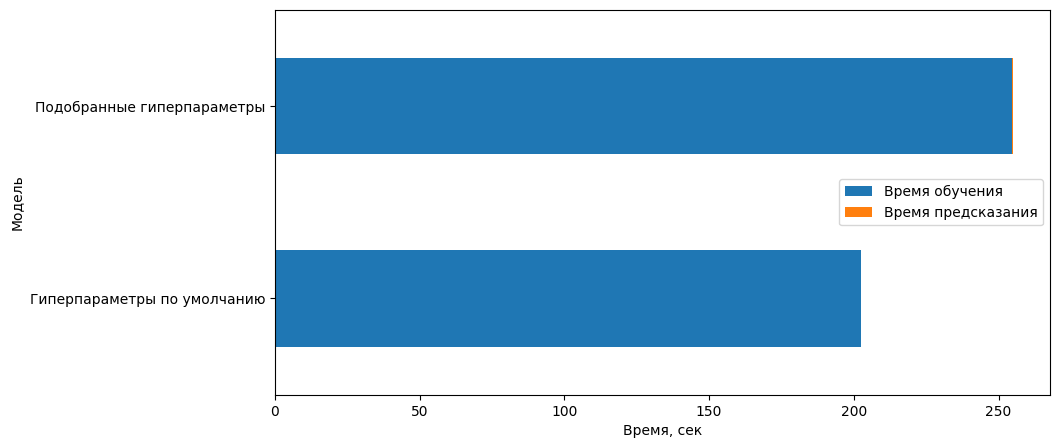

In [61]:
ax = results.sort_values('Общее время', ascending=True)[['Время обучения', 'Время предсказания']].plot(kind="barh", stacked=True, figsize=(10, 5), xlabel='')
ax.set_xlabel("Время, сек")
plt.show()

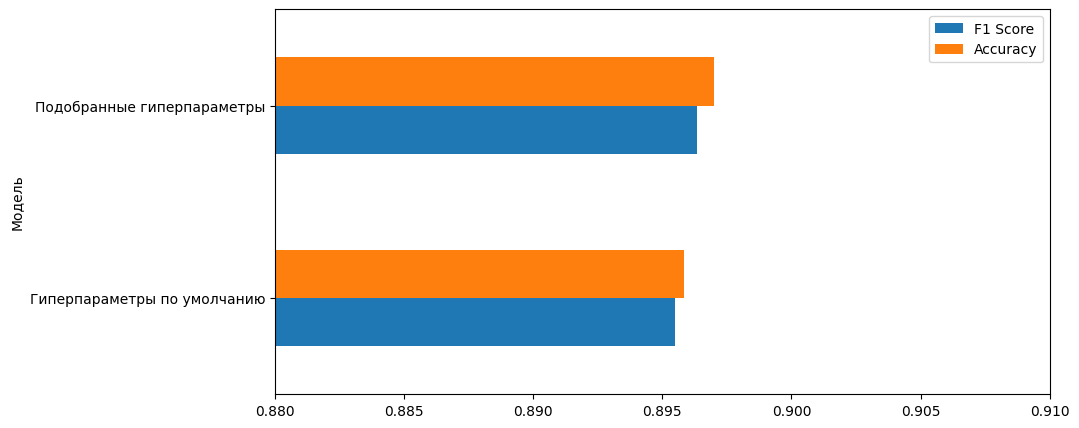

In [63]:
ax = results.sort_values('Accuracy', ascending=True)[['F1 Score', 'Accuracy']].plot(kind="barh", stacked=False, figsize=(10, 5), xlabel='', xlim=(0.88, 0.91))
plt.show()

Видно, что с оптимальными гиперпараметрами значения метрик эффективности модели увеличились.

## Выводы

В этой работе нами было представлено решение задачи мультиклассовой классификации изображений. Были проведены анализ исходных данных и эксперименты по поиску наиболее оптимальной модели для поставленной задачи.

В качестве семейств моделей выступали:
1. Линейные модели (логистическая регрессия, перцептрон, пассивно-агрессивный классификатор).
2. Метод ближайших соседей.
2. Наивные байесовские классификаторы (гауссовский и мультибиномиальный).
3. Деревья решений (простое дерево решений).
4. Ансамбли на основе деревьев (случайный лес, дополнительные деревья, градиентный бустинг).

Очевидный отрыв в показателях точности показали ансамбли - использовение нескольких моделей совместно эффективнее использования одной. 

После выбора семейства ансамблей моделей в качестве перспективного следовало выбрать лучшую модель. Ей стал градиентный бустинг. Несмотря на большее время обучения относительно всех других моделей, достигнуть такой же эффективности при меньшем времени обучения при использовании других ансамблевых методов не получалось, так как бэггинг сработал хуже бустинга.


После выбора оптимальной и перспективной модели были подобраны наилучшие гиперпараметры, максимизирующие точность предказаний (процент совпадения предсказанных и истинных классов объектов). 

Сравнения настроенной модели с исходной показали увеличение времени обучения на *25%* и обоих метрик точности, *Accuracy* и *F1-Score*.